**Importing the PGMPY library**

In [1]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import networkx as nx
from matplotlib import pyplot as plt
from pgmpy.inference import BeliefPropagation
import pydot

**Problem 1**

Draw the moral graph, triangulated graph and the junction tree. Explain why the "running intersection property" is satisfied in your junction tree.

**Creating our PGM model and creating all the nodes**

In [3]:
G=BayesianModel()
G.add_nodes_from(['asia','tub','either','smoke','lung','bronc','xray','dysp'])

**Adding the edges to the model**

In [4]:
G.add_edge('asia', 'tub')
G.add_edge('tub', 'either')
G.add_edge('smoke', 'lung')
G.add_edge('smoke', 'bronc')
G.add_edge('bronc','dysp')
G.add_edge('lung', 'either')
G.add_edge('either', 'xray')
G.add_edge('either', 'dysp')



**Plotting  the edges and nodes**

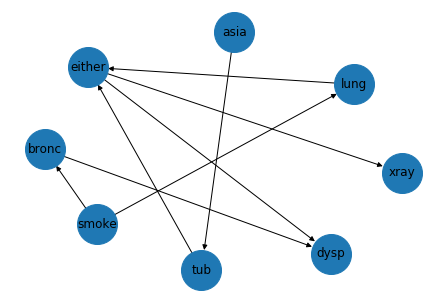

In [5]:
nx.draw(G,node_size=1600,with_labels=True)

**Forming the CPD tables**

In [6]:
asia = TabularCPD(variable='asia',variable_card=2,values=[[0.01],[0.99]])

In [7]:
tub = TabularCPD(variable='tub',variable_card=2,values=[[0.05,.01],[0.95,.99]],evidence=['asia'],evidence_card=[2])

In [8]:
smoke = TabularCPD(variable='smoke',variable_card=2,values=[[0.5],[0.5]])

In [9]:
lung = TabularCPD(variable='lung',variable_card=2,values=[[0.1,.01],[0.9,0.99]],evidence=['smoke'],evidence_card=[2])

In [10]:
bronc = TabularCPD(variable='bronc',variable_card=2,values=[[0.6,0.3],[0.4,0.7]],evidence=['smoke'],evidence_card=[2])

In [11]:
either = TabularCPD(variable='either',variable_card=2,values=[[1,1,1,0],[0,0,0,1]],evidence=['lung','tub'],
                    evidence_card=[2,2])


In [12]:
xray = TabularCPD(variable='xray',variable_card=2,values=[[.98,.05],[.02,.95]],evidence=['either'],evidence_card=[2])

In [13]:
dysp = TabularCPD(variable='dysp',variable_card=2,values=[[0.9,0.7,0.8,.1],[0.1,0.3,0.2,0.9]],
                  evidence=['bronc','either'],
                    evidence_card=[2,2])

In [14]:
G.add_cpds(asia,smoke,tub,lung,bronc,either,xray,dysp)

**Plotting the CPD tables**

In [15]:
for cpd in G.get_cpds():
    print("\nCPD of {variable}:".format(variable=cpd.variable))
    print(cpd)


CPD of asia:
+---------+------+
| asia(0) | 0.01 |
+---------+------+
| asia(1) | 0.99 |
+---------+------+

CPD of smoke:
+----------+-----+
| smoke(0) | 0.5 |
+----------+-----+
| smoke(1) | 0.5 |
+----------+-----+

CPD of tub:
+--------+---------+---------+
| asia   | asia(0) | asia(1) |
+--------+---------+---------+
| tub(0) | 0.05    | 0.01    |
+--------+---------+---------+
| tub(1) | 0.95    | 0.99    |
+--------+---------+---------+

CPD of lung:
+---------+----------+----------+
| smoke   | smoke(0) | smoke(1) |
+---------+----------+----------+
| lung(0) | 0.1      | 0.01     |
+---------+----------+----------+
| lung(1) | 0.9      | 0.99     |
+---------+----------+----------+

CPD of bronc:
+----------+----------+----------+
| smoke    | smoke(0) | smoke(1) |
+----------+----------+----------+
| bronc(0) | 0.6      | 0.3      |
+----------+----------+----------+
| bronc(1) | 0.4      | 0.7      |
+----------+----------+----------+

CPD of either:
+-----------+---------+

In [142]:
moral = G.to_markov_model()
triangulate = moral.triangulate()
junction_tree = triangulate.to_junction_tree()

**Generating the moral graph**

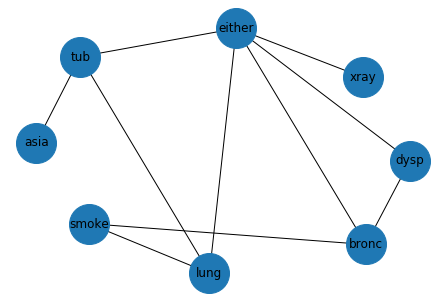

In [143]:
nx.draw(moral,with_labels=True,node_size=1600)

**Displaying the Triangulate**

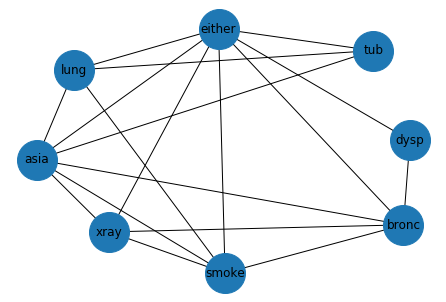

In [144]:
nx.draw(triangulate, with_labels=True,node_size=1600,pos=nx.spring_layout(triangulate))


**Displaying the Junction Tree**

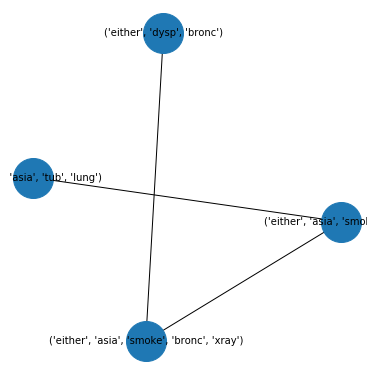

In [145]:
plt.figure(figsize=(5,5))

nx.draw(junction_tree, with_labels=True,node_size=1600,pos=nx.spring_layout(junction_tree),font_size=10)
plt.tight_layout()
plt.show()


**Nodes from the above junction tree**

In [146]:
junction_tree.nodes

NodeView((('either', 'asia', 'smoke', 'bronc', 'xray'), ('either', 'asia', 'smoke', 'lung'), ('either', 'dysp', 'bronc'), ('either', 'asia', 'tub', 'lung')))

**Running intersection property**

If a variable is present in two cliques, then it must be present in all the remining cliques, on the path that connects them.From the above represntation of the junction tree, we see the first node (either,asia,tub,lung) and the last node (either,dysp,bronc) both contains 'either', hence it is also present in the remaining nodes which connects the path between these two nodes.

Similarly both 'either' and 'asia' are present in the first node(either,asia,tub,lung) and the third node(either,asia,smoke,bronc,xray), so the path that connects these two nodes i.e the second node also contains both 'either' and 'asia'. Thus the running intersection property holds for the abov junction tree.

**Finding the joint probability of "tub=yes, lung=yes, bronc=yes", given evidence that "asia=yes, xray=yes using message passing algorithm**


In [148]:
INFR = VariableElimination(G)
I=INFR.query(variables=['tub','lung','bronc'],evidence={'asia':0,'xray':0},joint=True)
print(I)

Eliminating: smoke: 100%|██████████| 3/3 [00:00<00:00, 255.56it/s]

+--------+----------+---------+-----------------------+
| tub    | bronc    | lung    |   phi(tub,bronc,lung) |
+========+==========+=========+=======================+
| tub(0) | bronc(0) | lung(0) |                0.0106 |
+--------+----------+---------+-----------------------+
| tub(0) | bronc(0) | lung(1) |                0.1413 |
+--------+----------+---------+-----------------------+
| tub(0) | bronc(1) | lung(0) |                0.0079 |
+--------+----------+---------+-----------------------+
| tub(0) | bronc(1) | lung(1) |                0.1778 |
+--------+----------+---------+-----------------------+
| tub(1) | bronc(0) | lung(0) |                0.2021 |
+--------+----------+---------+-----------------------+
| tub(1) | bronc(0) | lung(1) |                0.1370 |
+--------+----------+---------+-----------------------+
| tub(1) | bronc(1) | lung(0) |                0.1508 |
+--------+----------+---------+-----------------------+
| tub(1) | bronc(1) | lung(1) |                0

We can infer from the above table that the **P(tub=yes,lung=yes,bronc=yes| asia=yes,xray=yes)=0.0106**

**Problem 2**

Describe how the different terms on the right hand side of "p(V ) = p(a)p(t | a)p(s)p(l | s)p(b | s)p(e | t, l)p(d | e, b)p(x | e)" are distributed among the different juction tree clusters. Write out the messages using these terms and verify that the message passing algorithm indeed gives the cluster marginals.


In the formed clusters or cliques that we have generated in the below diagram , te messages can be passed in both directions. It being represnted by the blue and black color in the below diagram.
There are three types of actors which are associated with these clusters/cliques -source cluster, the intervening sepset, and the destination cluster.

As messages are passed the potentials of sepset and destination cliques are modified. The variables in the source cluster x that are not in the sepset R are eliminated and marginalized out and the potential of the sepset is calculated as follows:

$\phi$R=$\sum_{S/R} \phi x$

The second assignment to the destination cluster Y potential is as follows:

$\phi$Y=$\phi Y \frac{\phi R}{\phi R ^{old}}$

<table><tr>
<td> <img src="IMG2.jpeg" alt="Drawing" style="width: 350px;"/> </td>
<td> <img src="IMG1.jpeg" alt="Drawing" style="width: 430px;"/> </td>

</tr></table>

The above derivation shows there are four factors $\Psi(E,A,T,L) , \Psi(E,A,S,L) , \Psi(E,A,S,B,X) , \Psi(E,D,B)$ distributed among junction tree clusters.

$\Psi(E,A,T,L) = P(T|A)P(E|T,L)$

$\Psi(E,A,S,L) = \sum_T \Psi(E,A,T,L) P(L|S)$

$\Psi(E,A,S,B,X) = \sum_L \Psi(E,A,S,L) P(A) P(S) P(B|S) P(X|E)$

$\Psi(E,D,B) = \sum_{A,S,X} \Psi(E,A,S,B,X) P(D|E,B)$



From this derivation we conclude a message is passed from Cluster/Clique 1('E','A','T','L') to Cluster 2('E','A','S','L') where we are marginalising over 'T'.

In the same fashion a message is being passed from Cluster 2('E','A','S','L') to Cluster 3('E','A','S','B','X') marginalising over 'L'.

Message is being passed from Cluster 3(E,A,S,B,X) to Cluster 4('E','D','B') marginalising over 'A','S','X'.

And in the last cluster(Cluster 4,('E','D','B')) we are marginalising over 'B','D','E'.

In the last stage the final output is distributed in the reverse order so that the final marginal probabilities can be calculated for each cluster.

In [154]:
bp = BeliefPropagation(G)
bp.calibrate()

**Dispalying the cliques**

In [155]:
bp.get_cliques()

NodeView((('either', 'asia', 'smoke', 'bronc', 'xray'), ('either', 'asia', 'smoke', 'lung'), ('either', 'dysp', 'bronc'), ('either', 'asia', 'tub', 'lung')))

**We have generated the sepsets in the below cell and have matched it with our derivation concluding that the message passing algorithm discussed above holds true.**

In [156]:
bp.get_sepset_beliefs()

{frozenset({('either', 'asia', 'smoke', 'bronc', 'xray'),
            ('either',
             'asia',
             'smoke',
             'lung')}): <DiscreteFactor representing phi(either:2, asia:2, smoke:2) at 0x1c38fd1d50>,
 frozenset({('either', 'asia', 'smoke', 'bronc', 'xray'),
            ('either',
             'dysp',
             'bronc')}): <DiscreteFactor representing phi(either:2, bronc:2) at 0x1c38ffe5d0>,
 frozenset({('either', 'asia', 'smoke', 'lung'),
            ('either',
             'asia',
             'tub',
             'lung')}): <DiscreteFactor representing phi(either:2, asia:2, lung:2) at 0x1c38ffea50>}

**[Optional] Problem 3: Find the joint probability with MCMC.**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import theano.tensor as T
from theano.compile.ops import as_op
import theano

In [2]:
a= [0.01,0.99]
s= [0.5,0.5]
l=[[0.1,0.9],[0.01,0.99]]
t=[[0.05,0.95],[0.01,0.99]]
x=[[0.98,0.02],[0.05,0.95]]
b=[[0.6,0.4],[0.3,0.7]]
e=[[[1,0],[1,0]],[[1,0],[0,1]]]
d=[[[0.9,0.1],[0.7,0.3]],[[0.8,0.2],[0.1,0.9]]]

with pm.Model() as model:
    
  asia = pm.Categorical('asia',p=np.array(a))
  smoke = pm.Categorical('smoke',p=np.array(s))
  lp=theano.shared(np.array(l))
  lp_0=lp[smoke]
  lung=pm.Categorical('lung',p=lp_0)

  bp=theano.shared(np.array(b))
  bp_0=bp[smoke]
  bronc=pm.Categorical('bronc',p=bp_0)

  tp=theano.shared(np.array(t))
  tp_0=tp[asia]
  tub=pm.Categorical('tub',p=tp_0)

  ep=theano.shared(np.array(e))
  ep_0=ep[lung,tub]
  either=pm.Categorical('either',p=ep_0)

  xp=theano.shared(np.array(x))
  xp_0=xp[either]
  xray=pm.Categorical('xray',p=xp_0)

  dp=theano.shared(np.array(d))
  dp_0=dp[bronc,either]
  dysp=pm.Categorical('dysp',p=dp_0)

In [3]:
with model:
    trace = pm.sample(20000)

Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [asia, smoke, lung, bronc, tub, either, xray, dysp]
Sampling 2 chains, 0 divergences: 100%|██████████| 41000/41000 [00:32<00:00, 1247.19draws/s]


In [4]:
a=trace['asia']
s=trace['smoke']
l=trace['lung']
t=trace['tub']
b=trace['bronc']
e=trace['either']
d=trace['dysp']
x=trace['xray']

df = pd.DataFrame(list(zip(a,s,l,t,b,e,d,x)) , columns = ['asia', 'smoke','lung','tub','bronc','either','dysp','xray'])  

We see that the row with index 29 has the maximum count from the table

In [5]:
df.groupby(['asia', 'smoke','lung','tub','bronc','either','dysp','xray']).size().reset_index(name='Count').sort_values(['Count'], ascending=False)

,asia,smoke,lung,tub,bronc,either,dysp,xray,Count
29,1,1,1,1,1,1,1,1,12569
15,1,0,1,1,0,1,0,1,7314
21,1,0,1,1,1,1,1,1,6544
23,1,1,1,1,0,1,0,1,4116
17,1,0,1,1,0,1,1,1,3201
25,1,1,1,1,0,1,1,1,1781
27,1,1,1,1,1,1,0,1,1411
19,1,0,1,1,1,1,0,1,701
28,1,1,1,1,1,1,1,0,630
14,1,0,1,1,0,1,0,0,398


**The sample Asia=no,Smoke=no,Lung=no,Tub=no,Bronc=no,Either=no,Dysp=no,Xray=no) occurs the most number of times in MCMC sampling
Thus after calcuting:**
**The joint probabilty is  0.2903**


Reference:
https://gist.github.com/tbsexton/1349864212b25cce91dbe5e336d794b4

